MISTAKES

I made a lot of mistakes while working on this project.  Some of these I caught and corrected during the process, and there were a few that I discovered towards the end.  The end result of my TNet and MNet were significantly worse on the celebrity dataset, so I quickly corrected errors and retrained a new network over a weekend.  Here is the list of the big errors that I believe I've made.

1. I had looked through the dataset and did not find repeated people.  However, after doing another glance, I found that there were definitely repeats.  Not sure exactly how many but this could have impacted the way that the 'test' set evaluated the model.  I had initially ignored the given train/test split provided by the authors of the paper as I wanted to create my own.  However, that was shortsighted and I generated a new dataset using their provided split.  It's hard to tell exactly how impactful the occasional duplication was but I fixed the issue for the second model.


2. I have a strong feeling that cropping out the images from their backgrounds and giving new backgrounds ended up being counter productive.  Jagged edges caused by imperfect ground truch mapping alongside drastic shifts in brightness between the background image and the person made it much easier to learn on the training set.  However, this is not true of real images and I believe this caused a lot of issues.  Even for images of people who did not show up in the training set (I checked manually), the results were really good.  However, due to the big drop off in quality towards the challenge dataset, I think it's clear that the new backgrounds made it easier, not harder, to handle.


3. Another issue was that I generated image augmentation during dataset creation, outside of the dataloader.  Even though each image was turned into 15 images, they were the same 15 images regardless of epoch.  This is a somewhat minor detail, but I made adjustments to the ImageDataset class object that performed the rotation and cropping of the image with each iteration. Therefore, each epoch of the original is equal to ~15 epochs of the new dataset.  However, I was able to train for 400 epochs for the new model and only ran for 10 epochs on the old.


4. Another big issue has to do with the size of the image.  Both models perform better when given an image the same dimensions as the data they were trained on.  In theory, I could have randomly resized the training data in order to compensate for this weakness, but this did not occur to me until I started writing this report and comparing the two models.  Regardless, another big impact that size had was the capacity of the GPU.  I had to make cuts to the neural networks and only run on a batch size of 1 in order to be able to fit the 600X800 images.  However, when I converted all images to 100X100 I was not only able to maintain the integrity of the UNet structure and run batches of 16, but I was able to train both the TNet and MNet together.  I named this new network the GluNet (GNet).  This is a much better strategy as it allows for both networks to learn from each other and work together.


Overall, the biggest lesson I've learned is to start simple.  Build something standard and see how well it works.  Then it's possible to troubleshoot where issues with data are coming from and what could be done to fix it.  I spent way too much time working on randomly adding backgrounds when a simpler approach blew that out of the water.

In [1]:
# Importing the required libraries

import os
from os import path
from tqdm import tqdm
import random

import cv2
from matplotlib import pyplot as plt
from PIL import Image

import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision

from Backend import UNet, GluNet, Cropper

In [11]:
CURRENT_DIR = path.abspath(path.curdir)
CELEB_DIR = CURRENT_DIR + '/Celeb Data/img_align_celeba/'
CHALLENGE_DATA = os.listdir(CELEB_DIR)
TRANSFORM = transforms.Compose([transforms.ColorJitter(brightness=0.75),transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
cropper = Cropper() # Model attempt 1
GNet = GluNet()

GNET EPOCHS

I'm well aware of the danger of overfitting, however I'm not so confident I understand it at a practical level.  Here is the graph of the losses throughout the 400 epochs of gnet training.

![Original Image](https://github.com/alexikerd/PortraitSegmentation/blob/master/Examples/Losses.PNG?raw=true)

I believe that the optimal epoch to pull from is in the 200-300 range.  I'm going to test this by evaluating the results based on epoch for the challenge data.  I've written a function that will randomly pull examples from the data, but is also capable of taking the name of a file as an input.  It then compares the results of the model in intervals of 50 epochs.

In [12]:
def compare_epochs(GNet,image=None):
    
    if image:
        sample = Image.open(CELEB_DIR + image).resize((100,100))
    else:
        sample = Image.open(CELEB_DIR + random.choice(CHALLENGE_DATA)).resize((100,100))
    
    f, axarr = plt.subplots(2,9,figsize=(15,15),sharex=True)
    axarr[0,0].set_title('Original Image')
    axarr[1,0].set_title('Original Image')
    [axi.set_axis_off() for axi in axarr.ravel()]
    axarr[0,0].imshow(np.asarray(sample))
    axarr[1,0].imshow(np.asarray(sample))
    
    for i in range(8):
            
            GNet.load_state_dict(torch.load(CURRENT_DIR + f'/Models/Versions/COMP/GNET COMP v{(i+1)*50}'))
            
            with torch.no_grad():
                trimap, matte = GNet(TRANSFORM(sample).unsqueeze(0))
 
            axarr[0,i+1].set_title(f'Epoch {(i+1)*50}')
            axarr[1,i+1].set_title(f'Epoch {(i+1)*50}')
            axarr[0,i+1].imshow(trimap.squeeze().numpy().transpose(1,2,0))
            axarr[1,i+1].imshow(matte.squeeze().numpy(),cmap="gray")
            
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.tight_layout()
    plt.show()

This is a perfect example of what I was worried about in the beginning of the project.  There are quite a few examples of distortions near the top of the image.  It looks like hair and extends out of the head but in reality it is just an unfortunate distortion.  By epoch 150, the model has learned to ignore these kinds of situations, which is very impressive.

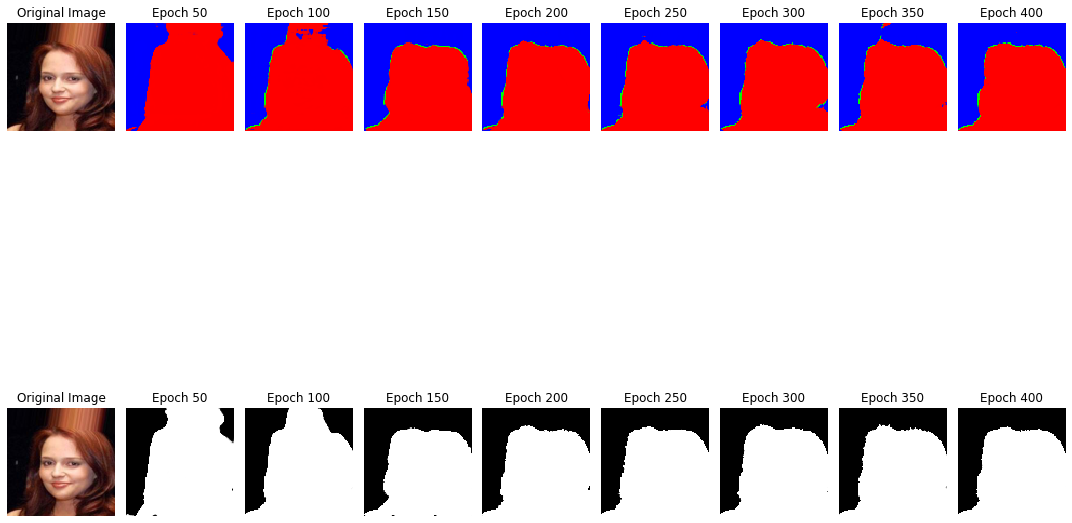

In [13]:
compare_epochs(GNet)

This is another example where the model has effectively learned by epoch 150.  The important thing to note from this example is that the predicted trimap is significantly nosier than the matte prediction.  It seems to be doing what was intended by identifying uncertain regions.  The matte has become much better at looking at the trimap predictions and has learned what to ignore.  Any noisy uncertainty, such as the tie or the background at the top left, gets correctly categorized by the alpha matte.  Another interesting feature is that the model seems to regress when it hits epoch 400, having a big mass at the right side of the person's face.

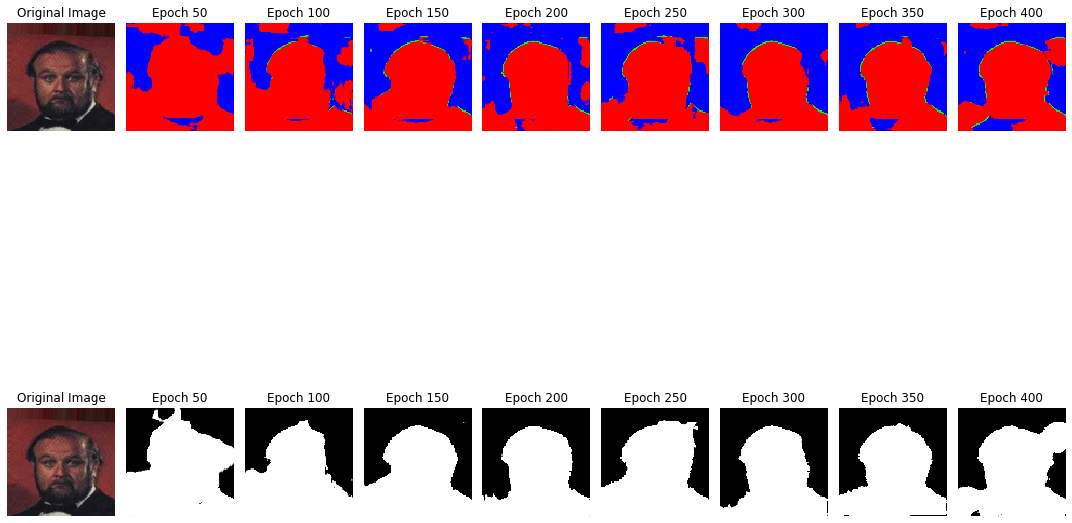

In [15]:
compare_epochs(GNet)

The next two images help to demonstrate that epoch 150 seems to have the best consistency in ignoring the initial mistakes but also not overfitting.  I was not expecting this, but I'll be using Epoch 150 when comparing GNet to Cropper.

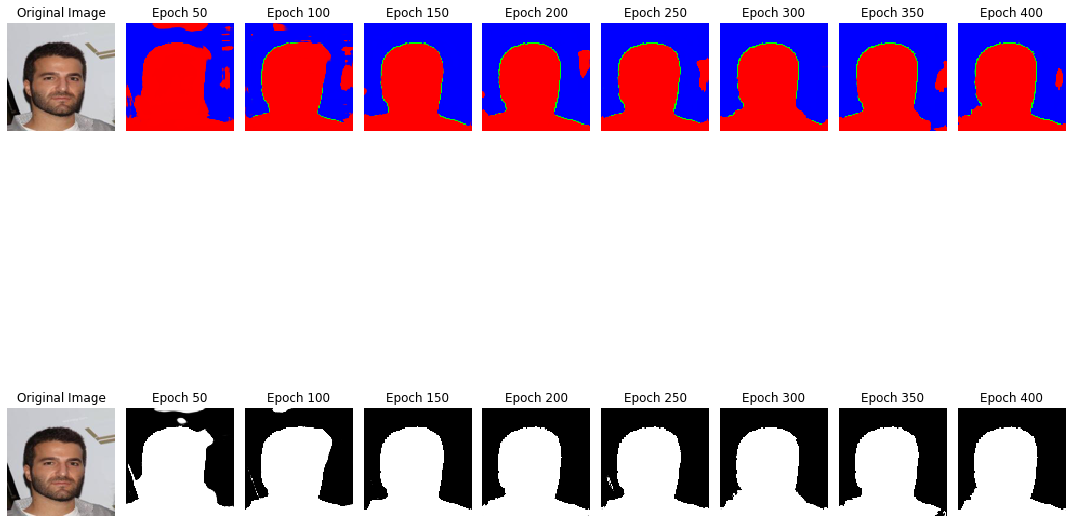

In [19]:
compare_epochs(GNet)

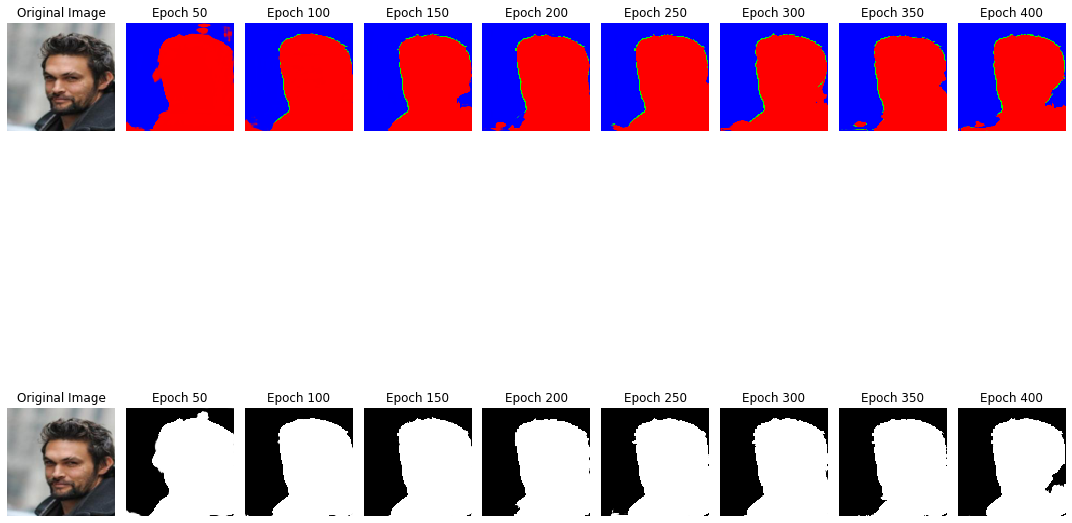

In [16]:
compare_epochs(GNet)

In [37]:
def compare_models(GNet,cropper,image=None):
    
    if image:
        sample = Image.open(CELEB_DIR + image)
    else:
        sample = Image.open(CELEB_DIR + random.choice(CHALLENGE_DATA))


    matte, _ = cropper(sample)

    with torch.no_grad():
        trimap = cropper.TNet(TRANSFORM(sample.resize(((600,800)))).unsqueeze(0))
        G_trimap, G_matte = GNet(TRANSFORM(sample.resize((100,100))).unsqueeze(0))

    f, axarr = plt.subplots(2,3,figsize=(5,5))

    axarr[0,0].set_title("Input Image")
    axarr[0,1].set_title("Cropper Prediction")
    axarr[0,2].set_title("GluNet Prediction")
    [axi.set_axis_off() for axi in axarr.ravel()]

    axarr[0,0].imshow(np.asarray(sample))
    axarr[0,1].imshow(cv2.resize(trimap.squeeze().numpy().transpose(1,2,0),(100,100)))
    axarr[1,1].imshow(cv2.resize(matte,(100,100)),cmap="gray")
    axarr[0,2].imshow(G_trimap.squeeze().numpy().transpose(1,2,0))
    axarr[1,2].imshow(G_matte.squeeze().numpy(),cmap="gray")

    plt.tight_layout();

In [24]:
GNet = GluNet()
GNet.load_state_dict(torch.load(CURRENT_DIR + '/Models/Versions/COMP/GNET COMP v150'));

When it comes to the hair distortion, GluNet blows my previous nn out of the water.  The top of the head in the predicted matte does not look normal at all, but the model is able to correctly understand that this was a distortion in the image.

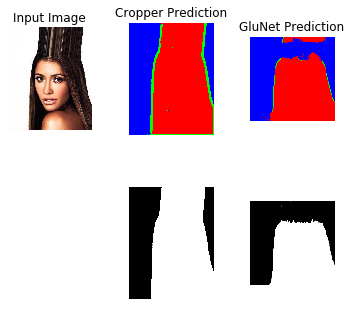

In [29]:
compare_models(GNet,cropper)

Here, cropper fails to understand that the hair is a part of the person, while GNet is able to get the relative shape of her head.

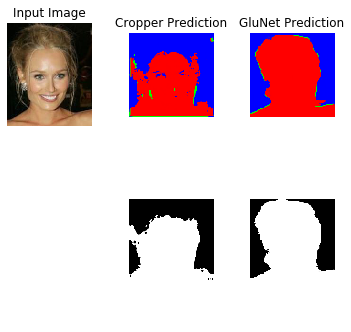

In [38]:
compare_models(GNet,cropper)

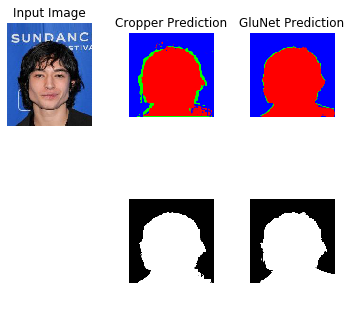

In [39]:
compare_models(GNet,cropper)